## Assignment - Part 1

In [16]:
import requests
import json

# API endpoint URL
api_url = 'https://sm-smartconnect.azurewebsites.net/api/DistanceSwap/GetByZoneType?id=154'

# Headers (if required, based on the information from the network request)
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36',
    'Accept': 'application/json'
}

# Make the GET request to fetch the data
response = requests.get(api_url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Save the JSON data to a file for further review
    with open("battery_swapping_stations.json", "w") as f:
        json.dump(data, f, indent=4)
    
    print("Data successfully fetched and saved to 'battery_swapping_stations.json'")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")
    print(response.content)


Data successfully fetched and saved to 'battery_swapping_stations.json'


In [17]:
# Load the JSON data
with open("battery_swapping_stations.json", "r") as f:
    stations_data = json.load(f)

# Check if 'result' contains the stations
if 'result' in stations_data:
    # Extract the 'result' field
    stations = stations_data['result']
    
    # Print the full structure of 'result' to understand how it's organized
    print("Result structure:")
    print(json.dumps(stations, indent=4))
else:
    print("No 'result' field found in the JSON data")


Result structure:
{
    "home": {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": [
                        76.7794,
                        30.7333
                    ]
                },
                "properties": {
                    "title": "Chandigarh"
                }
            },
            {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": [
                        76.7179,
                        30.7046
                    ]
                },
                "properties": {
                    "title": "Mohali"
                }
            },
            {
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": [
                        76

In [18]:
import pandas as pd
import json

# Load the JSON data
with open("battery_swapping_stations.json", "r") as f:
    stations_data = json.load(f)

# Check if 'about' exists and extract the list of features
if 'result' in stations_data and 'about' in stations_data['result']:
    features = stations_data['result']['about']['features']  # Extract the list of features from 'about'

    # Prepare a list to hold station details
    station_list = []
    
    # Loop through each feature and extract coordinates and properties
    for feature in features:
        # Ensure 'geometry' and 'properties' exist in each feature
        if 'geometry' in feature and 'properties' in feature:
            coordinates = feature['geometry']['coordinates']  # Extract coordinates (Longitude, Latitude)
            properties = feature['properties']  # Extract properties (like title)
            
            # Store the station details in a dictionary
            station_info = {
                'Name': properties.get('title', 'N/A'),  # Use 'title' as the station name
                'Latitude': coordinates[1],  # Latitude is the second item in coordinates
                'Longitude': coordinates[0]  # Longitude is the first item in coordinates
            }
            station_list.append(station_info)
    
    # Convert the list to a pandas DataFrame
    df_stations = pd.DataFrame(station_list)

    # Save to CSV
    df_stations.to_csv('battery_swapping_stations.csv', index=False)

    # Display the DataFrame
    print(df_stations.head())

else:
    print("No 'about' field or 'features' found in the JSON data")


                         Name   Latitude  Longitude
0  Platinum-Motors-Chandigarh  30.711684  76.806394
1         Chandigarh-Zirkapur  30.676800  76.809480
2       GMP Motors Chandigarh  30.702948  76.802712
3    Chandigarh-PGI-Manimajra  30.716930  76.838000
4      Chandigarh-Elante-Mall  30.708830  76.804480


In [19]:
df_stations.head()

,Name,Latitude,Longitude
0,Platinum-Motors-Chandigarh,30.711684,76.806394
1,Chandigarh-Zirkapur,30.676800,76.809480
2,GMP Motors Chandigarh,30.702948,76.802712
3,Chandigarh-PGI-Manimajra,30.716930,76.838000
4,Chandigarh-Elante-Mall,30.708830,76.804480


In [20]:
import os
os.chdir(r"C:\Users\risha\Downloads\EV_Analysis\Data")

In [21]:
import folium

m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)  # Centered on India
    
# Add each station as a marker on the map
for _, row in df_stations.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Name']
    ).add_to(m)
    
# Save the map to an HTML file
m.save("battery_swapping_stations_map.html")

# Display the map
m

## Battery swapping stations - Sun Mobility

# ev.delhi.gov.in Data

## Getting Charging stations

In [9]:
import os
os.chdir(r"C:\Users\risha\Downloads\EV_Analysis\Data")

In [10]:
import requests
from bs4 import BeautifulSoup
import re
import json
import pandas as pd

# Suppress only the InsecureRequestWarning
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# URL of the page that contains the charging stations data
url = 'https://ev.delhi.gov.in/charging-station'

# Fetch the HTML of the page with SSL verification disabled
response = requests.get(url, verify=False)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the script tag containing the 'all_locations' data
    script_tag = soup.find('script', string=re.compile('all_locations'))
    
    if script_tag:
        # Use regular expression to extract the JSON-like object
        match = re.search(r'let all_locations = (\[.*?\]);', script_tag.string, re.DOTALL)
        
        if match:
            # Get the matched string
            all_locations_json = match.group(1)
            
            # Cleaning steps to fix any issues with the JSON structure:
            # 1. Replace single quotes with double quotes
            all_locations_json = all_locations_json.replace("'", '"')
            
            # 2. Escape backslashes to prevent invalid escape sequences
            all_locations_json = all_locations_json.replace("\\", "\\\\")
            
            # 3. Remove trailing commas inside the JSON object (if any)
            all_locations_json = re.sub(r',\s*}', '}', all_locations_json)  # Handle commas before closing braces
            all_locations_json = re.sub(r',\s*]', ']', all_locations_json)  # Handle commas before closing brackets
            
            # Try to parse the cleaned JSON-like object
            try:
                all_locations = json.loads(all_locations_json)
                
                # Convert the list to a DataFrame
                df = pd.DataFrame(all_locations)
                
                # Display the DataFrame
                print(df)
                
                # Additional check: Number of charging stations in the data source vs obtained
                total_stations = len(all_locations)
                obtained_stations = len(df)
                
                print(f"Total charging stations in source: {total_stations}")
                print(f"Charging stations obtained in DataFrame: {obtained_stations}")
            
            except json.JSONDecodeError as e:
                print(f"Failed to parse JSON: {e}")
        else:
            print("Failed to extract 'all_locations' data.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")


                                               address postal_code capacity  \
0          175, Patparganj Industrial Area, Patparganj      110092    3.3kw   
1    A-1/1, Hardev Puri, 100 ft Road, Nathu Colony ...      110025    3.3kw   
2                    Plot no. 1-A, Shiv vihar, Nangloi      110019    3.3kw   
3                     M block Market Gearter Kailash 1      110041    3.3kw   
4                     Shop No-48, NH-5, NIT, Faridabad      110052    3.3kw   
..                                                 ...         ...      ...   
886  Shop No-1, Rajeev Vihar, Khora Colony, Sector-...      201301            
887  Shop No-1, Sector-4, Near Ek Mutri Gol Chakkar...      201301            
888  House No-93, Shop No-PVT-1, Ground Floor, Bloc...      110085            
889  Shop No-RZ-62-K/6A, Ground Flour, Vashist Park...      110046            
890  Shop No-B-308, First Floor, Madanpur Khadar Ex...      110076            

          city     close cost_per_unit country   la

In [11]:
df.shape

(891, 23)

In [12]:
df.head()

,address,postal_code,capacity,city,close,cost_per_unit,country,latitude,longitude,open,...,charger_type,"if_battery_swap_station,_no._of_dockets",id,vendor,charging_type,contact_number,name,coordinates,timing,no_of_chargers
0,"175, Patparganj Industrial Area, Patparganj",110092,3.3kw,New Delhi,21:00:00,15,India,28.642213,77.314837,08:00:00,...,LEV AC,nil,S01,Massive Mobility,Charging,,,"{'latitude': '28.642213', 'longitude': '77.314...",08:00:00 - 21:00:00,2
1,"A-1/1, Hardev Puri, 100 ft Road, Nathu Colony ...",110025,3.3kw,New Delhi,21:00:00,15,India,28.689606,77.298775,09:00:00,...,LEV AC,nil,S02,Massive Mobility,Charging,,,"{'latitude': '28.689606', 'longitude': '77.298...",09:00:00 - 21:00:00,1
2,"Plot no. 1-A, Shiv vihar, Nangloi",110019,3.3kw,New Delhi,21:00:00,15,India,28.661666,77.061585,10:00:00,...,LEV AC,nil,S03,Massive Mobility,Charging,,,"{'latitude': '28.661666', 'longitude': '77.061...",10:00:00 - 21:00:00,10
3,M block Market Gearter Kailash 1,110041,3.3kw,New Delhi,21:00:00,15,India,28.550284,77.235053,11:00:00,...,LEV AC,nil,S04,Massive Mobility,Charging,,,"{'latitude': '28.550284', 'longitude': '77.235...",11:00:00 - 21:00:00,1
4,"Shop No-48, NH-5, NIT, Faridabad",110052,3.3kw,New Delhi,21:00:00,15,India,28.405363,77.305530,12:00:00,...,LEV AC,nil,S05,Massive Mobility,Charging,,,"{'latitude': '28.405363', 'longitude': '77.305...",12:00:00 - 21:00:00,1


In [38]:
df['if_battery_swap_station,_no._of_dockets'].unique()

array(['nil', 'NILL', '', 'Nil', 'S12', 'S14', 'S15', 'S16', 'S18', 'S19',
       'S28', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35', 'S36', 'S37',
       'S38', 'S39', 'S40'], dtype=object)

In [14]:
# Check how many rows are not 'nil', 'NILL', or empty
non_nil_count = df[df['if_battery_swap_station,_no._of_dockets'].str.lower().isin(['nil', 'nill', '']) == False].shape[0]

print(f"Number of non-nil entries: {non_nil_count}")


Number of non-nil entries: 21


In [22]:
# import folium
# import pandas as pd

# # Assuming df is your DataFrame with the charging stations data

# # Convert 'latitude' and 'longitude' columns to numeric, forcing errors to NaN
# df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
# df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# # Drop rows where 'latitude' or 'longitude' are NaN
# df = df.dropna(subset=['latitude', 'longitude'])

# # Check the condition for non-nil entries in the 'if_battery_swap_station,_no._of_dockets' column
# condition = df['if_battery_swap_station,_no._of_dockets'].str.lower().isin(['nil', 'nill', '']) == False

# # Create a folium map centered around the mean latitude and longitude
# map_center = [df['latitude'].mean(), df['longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=12)

# # Add markers for each charging station
# for idx, row in df.iterrows():
#     if condition[idx]:  # Mark non-nil entries with a different color
#         marker_color = 'green'
#     else:
#         marker_color = 'red'
    
#     folium.Marker(
#         location=[row['latitude'], row['longitude']],
#         popup=f"Address: {row['address']}<br>Capacity: {row['capacity']}<br>Postal Code: {row['postal_code']}",
#         tooltip=row['city'],
#         icon=folium.Icon(color=marker_color)
#     ).add_to(m)

# # Save the map to an HTML file and display
# m.save('charging_stations_and_battery_swapping_stations_delhi.html')
# m


In [93]:
#trying evyatra.beeindia data

In [98]:
import requests
import json

# Define the API endpoint
api_url = "https://evyatra.beeindia.gov.in/bee-ev-backend/searchbystationname"

# Function to search for a station by name using the API
def search_station_by_name(station_name):
    payload = station_name.encode('utf-8')  # Ensure the station name is properly encoded
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36 OPR/113.0.0.0',
        'X-Requested-With': 'XMLHttpRequest',
    }
    
    try:
        response = requests.post(api_url, headers=headers, data=f'stationname={payload}')
        if response.status_code == 200:
            station_details = response.json()
            print(f"Results for station '{station_name}': {station_details}")
            return station_details
        else:
            print(f"Failed to search for station '{station_name}'. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error fetching details for station '{station_name}': {e}")

# List of sample station names to search (you can expand this)
station_names = [
    "Ather",     # Example for Ather stations
    "Tata",      # Example for Tata Power EV stations
    "ChargeGrid",# Example for ChargeGrid stations
    # Add more patterns or station names as needed
]

# Collecting station data
stations_data = []

# Loop through station names and get data
for name in station_names:
    details = search_station_by_name(name)
    if details:
        stations_data.append(details)

# Save the station data to a JSON file
if stations_data:
    with open('station_search_results.json', 'w') as f:
        json.dump(stations_data, f, indent=4)
    print("Charging station data saved to 'station_search_results.json'.")
else:
    print("No station data collected.")


Results for station 'Ather': {'type': 'TRUE', 'message': ' DATA LOADED SUCCESSFULLY', 'result': 'TRUE', 'value': [{'id': 11131, 'lat': 10.080327, 'lng': 77.9777, 'cs_displayno': 23044140, 'station_name': ' ', 'address': 'Hotel Templecity,Nh 44 Madurai To Dindigul Highway ,Vadipatti,Vadipatti', 'st_owner': None, 'companyname': 'Zeon Charging', 'mobile_no': 9994806161, 'contactPerson': '', 'amenities': None, 'avg_cost_discom': None, 'opening_time': None, 'closing_time': None, 'is_tweenty_four_seven': 'f', 'city_name': 'Madurai'}, {'id': 42342, 'lat': 16.31450889825, 'lng': 80.234501885311, 'cs_displayno': 24071625, 'station_name': '-', 'address': '113 Talluru, Guntur District', 'st_owner': None, 'companyname': 'HINDUSTAN PETROLEUM CORPORATION LIMITED', 'mobile_no': '', 'contactPerson': '', 'amenities': None, 'avg_cost_discom': None, 'opening_time': None, 'closing_time': None, 'is_tweenty_four_seven': 'f', 'city_name': 'Parastyalluru'}, {'id': 39299, 'lat': 12.895235440557, 'lng': 77.5644

In [105]:
# import requests
# import json
# import time

# # Base URL for station search API
# base_url = "https://evyatra.beeindia.gov.in/bee-ev-backend/searchbystationname"

# # Headers (if needed)
# headers = {
#     "Content-Type": "application/x-www-form-urlencoded",
#     "Accept": "*/*",
#     "User-Agent": "Mozilla/5.0"
# }

# # List of station names (or letters) to search through
# search_terms = [chr(i) for i in range(65, 91)]  # A-Z letters
# station_data = []

# for term in search_terms:
#     print(f"Searching for stations with term: {term}")
    
#     try:
#         # Payload with search term
#         payload = {"search": term}

#         # Sending the POST request
#         response = requests.post(base_url, headers=headers, data=payload)
        
#         if response.status_code == 200:
#             data = response.json()
            
#             # Check if the response has station details
#             if data['type'] == 'TRUE' and 'value' in data:
#                 station_data.extend(data['value'])
#                 print(f"Found {len(data['value'])} stations for search term: {term}")
        
#         # Sleep for a short time to avoid overwhelming the server
#         time.sleep(1)
    
#     except Exception as e:
#         print(f"Error searching for term {term}: {e}")

# # Save collected station data to a JSON file
# with open('all_stations_data.json', 'w') as outfile:
#     json.dump(station_data, outfile, indent=4)

# print(f"Total stations found: {len(station_data)}")


Searching for stations with term: A
Found 10 stations for search term: A
Searching for stations with term: B
Found 10 stations for search term: B
Searching for stations with term: C
Found 10 stations for search term: C
Searching for stations with term: D
Found 10 stations for search term: D
Searching for stations with term: E
Found 10 stations for search term: E
Searching for stations with term: F
Found 10 stations for search term: F
Searching for stations with term: G
Found 10 stations for search term: G
Searching for stations with term: H
Found 10 stations for search term: H
Searching for stations with term: I
Found 10 stations for search term: I
Searching for stations with term: J
Found 10 stations for search term: J
Searching for stations with term: K
Found 10 stations for search term: K
Searching for stations with term: L
Found 10 stations for search term: L
Searching for stations with term: M
Found 10 stations for search term: M
Searching for stations with term: N
Found 10 statio

In [23]:
# Leave for now

In [24]:
import pandas as pd

# Step 1: Rename the columns in df_stations to match df
df_stations.rename(columns={'Name': 'address', 'Latitude': 'latitude', 'Longitude': 'longitude'}, inplace=True)

# Step 2: Add missing columns to df_stations with NaN or appropriate default values
# We fill with NaN for now; you can adjust if needed
missing_columns = [col for col in df.columns if col not in df_stations.columns]
for col in missing_columns:
    df_stations[col] = pd.NA

# Step 3: Add 'station_type' column to both DataFrames
df['station_type'] = 'Charging Station'
df_stations['station_type'] = 'Battery Swapping Station'

# Step 4: Concatenate the DataFrames
combined_df = pd.concat([df, df_stations], ignore_index=True)

# Step 5: Save the combined DataFrame to a new CSV file
combined_df.to_csv('combined_stations_with_types.csv', index=False)

# Step 6: Visualize the combined DataFrame using folium
import folium

# Convert 'latitude' and 'longitude' columns to numeric in the combined DataFrame
combined_df['latitude'] = pd.to_numeric(combined_df['latitude'], errors='coerce')
combined_df['longitude'] = pd.to_numeric(combined_df['longitude'], errors='coerce')

# Drop rows where 'latitude' or 'longitude' are NaN
combined_df = combined_df.dropna(subset=['latitude', 'longitude'])


In [25]:
combined_df.shape

(1440, 24)

In [30]:
combined_df.columns

Index(['address', 'postal_code', 'capacity', 'city', 'close', 'cost_per_unit',
       'country', 'latitude', 'longitude', 'open', 'payment_modes', 'staff',
       'available', 'charger_type', 'if_battery_swap_station,_no._of_dockets',
       'id', 'vendor', 'charging_type', 'contact_number', 'name',
       'coordinates', 'timing', 'no_of_chargers', 'station_type'],
      dtype='object')

In [34]:
combined_df['no_of_chargers'].unique()

array([2, 1, 10, 5, 3, 36, 18, 26, 34, 4, 20, 7, 12, 24, 6, 16, 8, 44, 14,
       30, 42, 40, 50, 28, 46, 22, 32, <NA>], dtype=object)

In [26]:

# Create a folium map centered around the mean latitude and longitude
map_center = [combined_df['latitude'].mean(), combined_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add markers for each station
for idx, row in combined_df.iterrows():
    # Set marker color based on station type
    if row['station_type'] == 'Battery Swapping Station':
        marker_color = 'blue'
    else:
        marker_color = 'green' if row['if_battery_swap_station,_no._of_dockets'].lower() not in ['nil', 'nill', ''] else 'red'
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Address: {row['address']}<br>Capacity: {row.get('capacity', 'N/A')}<br>Postal Code: {row.get('postal_code', 'N/A')}<br>Type: {row['station_type']}",
        tooltip=row['city'] if 'city' in row else '',
        icon=folium.Icon(color=marker_color)
    ).add_to(m)

# Save the map to an HTML file and display
m.save('combined_charging_battery_map.html')
m


In [8]:
import os
os.chdir(r"C:\Users\risha\Downloads\EV_Analysis\Data")

In [37]:
import pandas as pd

# Load the combined DataFrame (if not already loaded)
df_combined = pd.read_csv('combined_stations_with_types.csv')

# Define the bounding box for Delhi
# Approximate latitudes and longitudes for Delhi's bounding box (you can adjust this as needed)
min_latitude = 28.4  # South of Delhi
max_latitude = 28.9  # North of Delhi
min_longitude = 76.8  # West of Delhi
max_longitude = 77.4  # East of Delhi

# Filter the DataFrame based on the bounding box for Delhi
df_delhi = df_combined[
    (df_combined['latitude'] >= min_latitude) &
    (df_combined['latitude'] <= max_latitude) &
    (df_combined['longitude'] >= min_longitude) &
    (df_combined['longitude'] <= max_longitude)
]

# Alternatively, you can also filter based on city name if the 'city' column is accurate
# df_delhi = df_combined[df_combined['city'].str.contains("Delhi", case=False, na=False)]

# Save the filtered data to a new CSV
df_delhi.to_csv('delhi_filtered_stations.csv', index=False)

# Display some rows of the filtered DataFrame
print(f"Total stations in Delhi area: {df_delhi.shape[0]}")
print(df_delhi.head())


Total stations in Delhi area: 1172
                                             address  postal_code capacity  \
0        175, Patparganj Industrial Area, Patparganj     110092.0    3.3kw   
1  A-1/1, Hardev Puri, 100 ft Road, Nathu Colony ...     110025.0    3.3kw   
2                  Plot no. 1-A, Shiv vihar, Nangloi     110019.0    3.3kw   
3                   M block Market Gearter Kailash 1     110041.0    3.3kw   
4                   Shop No-48, NH-5, NIT, Faridabad     110052.0    3.3kw   

        city     close  cost_per_unit country   latitude  longitude      open  \
0  New Delhi  21:00:00           15.0   India  28.642213  77.314837  08:00:00   
1  New Delhi  21:00:00           15.0   India  28.689606  77.298775  09:00:00   
2  New Delhi  21:00:00           15.0   India  28.661666  77.061585  10:00:00   
3  New Delhi  21:00:00           15.0   India  28.550284  77.235053  11:00:00   
4  New Delhi  21:00:00           15.0   India  28.405363  77.305530  12:00:00   

   ... if

In [44]:
# Check the number of stations in each station_type category
station_type_counts = df_delhi['station_type'].value_counts()

# Display the result
print(station_type_counts)


station_type
Charging Station            758
Battery Swapping Station    414
Name: count, dtype: int64


In [55]:
import pandas as pd
import folium
from sklearn.cluster import DBSCAN
from folium.plugins import HeatMap

# Load the filtered Delhi DataFrame
df_delhi = pd.read_csv('delhi_filtered_stations.csv')

# Extract latitude and longitude data for clustering
coords = df_delhi[['latitude', 'longitude']].dropna()

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.01, min_samples=5).fit(coords)
df_delhi['cluster'] = dbscan.labels_

# Create a Folium map centered around Delhi
map_center = [28.6139, 77.2090]  # Static coordinates for Delhi
m = folium.Map(location=map_center, zoom_start=12)

# Add markers for each station, coloring by cluster and type (charging/swapping)
for idx, row in df_delhi.iterrows():
    marker_color = 'red' if row['station_type'] == 'Charging Station' else 'blue'
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        popup=f"Address: {row['address']}<br>Type: {row['station_type']}<br>Cluster: {row['cluster']}",
        color=marker_color,
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# Save map to HTML file
m.save('delhi_station_clusters_map.html')

# Create a heat map for station density
heat_data = [[row['latitude'], row['longitude']] for index, row in df_delhi.iterrows()]
m_heat = folium.Map(location=map_center, zoom_start=12)
HeatMap(heat_data).add_to(m_heat)

# Save heat map
m_heat.save('delhi_station_density_heatmap.html')

# Display information about the generated maps
print("Maps have been saved as 'delhi_station_clusters_map.html' and 'delhi_station_density_heatmap.html'.")


Maps have been saved as 'delhi_station_clusters_map.html' and 'delhi_station_density_heatmap.html'.


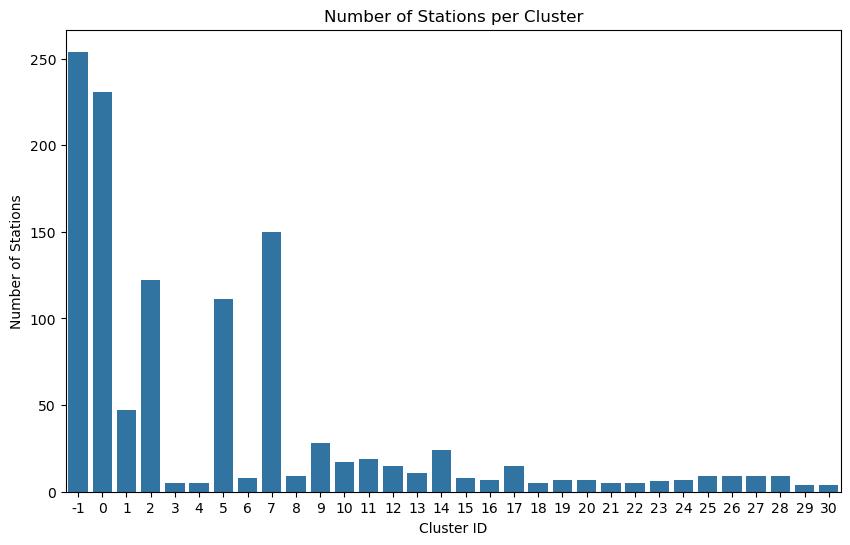

In [56]:
# Plot the number of stations in each cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df_delhi)
plt.title('Number of Stations per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Stations')
plt.show()


In [57]:
import pandas as pd
import folium
from sklearn.cluster import DBSCAN
from folium.plugins import HeatMap

# Load the filtered Delhi DataFrame
df_delhi = pd.read_csv('delhi_filtered_stations.csv')

# Extract latitude and longitude data for clustering
coords = df_delhi[['latitude', 'longitude']].dropna()

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.01, min_samples=5).fit(coords)
df_delhi['cluster'] = dbscan.labels_

# Step 1: Identify clusters with more than 50 stations
cluster_counts = df_delhi['cluster'].value_counts()
large_clusters = cluster_counts[cluster_counts > 50].index.tolist()

# Step 2: Filter the DataFrame for only clusters with more than 50 stations
df_large_clusters = df_delhi[df_delhi['cluster'].isin(large_clusters)]

# Step 3: Create a Folium map centered around Delhi
map_center = [28.6139, 77.2090]  # Static coordinates for Delhi
m_large_clusters = folium.Map(location=map_center, zoom_start=12)

# Step 4: Add markers for each station in large clusters, coloring by cluster and type
for idx, row in df_large_clusters.iterrows():
    marker_color = 'red' if row['station_type'] == 'Charging Station' else 'blue'
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        popup=f"Address: {row['address']}<br>Type: {row['station_type']}<br>Cluster: {row['cluster']}",
        color=marker_color,
        fill=True,
        fill_opacity=0.7
    ).add_to(m_large_clusters)

# Step 5: Save map to HTML file
m_large_clusters.save('delhi_large_clusters_map.html')

# Step 6: Create a heat map for large cluster station density
heat_data_large_clusters = [[row['latitude'], row['longitude']] for index, row in df_large_clusters.iterrows()]
m_heat_large_clusters = folium.Map(location=map_center, zoom_start=12)
HeatMap(heat_data_large_clusters).add_to(m_heat_large_clusters)

# Step 7: Save heat map
m_heat_large_clusters.save('delhi_large_clusters_heatmap.html')

# Display information about the generated maps
print("Maps of large clusters have been saved as 'delhi_large_clusters_map.html' and 'delhi_large_clusters_heatmap.html'.")


Maps of large clusters have been saved as 'delhi_large_clusters_map.html' and 'delhi_large_clusters_heatmap.html'.


In [48]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load the filtered Delhi DataFrame
df_delhi = pd.read_csv('delhi_filtered_stations.csv')

# Filter charging stations and battery swapping stations
charging_stations = df_delhi[df_delhi['station_type'] == 'Charging Station']
battery_swapping_stations = df_delhi[df_delhi['station_type'] == 'Battery Swapping Station']

# Create a Folium map centered around Delhi for charging stations
map_center = [28.6139, 77.2090]  # Static coordinates for Delhi
m_charging = folium.Map(location=map_center, zoom_start=12)

# Heatmap for charging stations
heat_data_charging = [[row['latitude'], row['longitude']] for index, row in charging_stations.iterrows()]
HeatMap(heat_data_charging).add_to(m_charging)

# Save heat map for charging stations
m_charging.save('charging_stations_heatmap.html')
print("Charging stations heatmap saved as 'charging_stations_heatmap.html'.")

# Create a Folium map centered around Delhi for battery swapping stations
m_swapping = folium.Map(location=map_center, zoom_start=12)

# Heatmap for battery swapping stations
heat_data_swapping = [[row['latitude'], row['longitude']] for index, row in battery_swapping_stations.iterrows()]
HeatMap(heat_data_swapping).add_to(m_swapping)

# Save heat map for battery swapping stations
m_swapping.save('battery_swapping_stations_heatmap.html')
print("Battery swapping stations heatmap saved as 'battery_swapping_stations_heatmap.html'.")


Charging stations heatmap saved as 'charging_stations_heatmap.html'.
Battery swapping stations heatmap saved as 'battery_swapping_stations_heatmap.html'.


In [39]:
df_combined[station_type]

Index(['address', 'postal_code', 'capacity', 'city', 'close', 'cost_per_unit',
       'country', 'latitude', 'longitude', 'open', 'payment_modes', 'staff',
       'available', 'charger_type', 'if_battery_swap_station,_no._of_dockets',
       'id', 'vendor', 'charging_type', 'contact_number', 'name',
       'coordinates', 'timing', 'no_of_chargers', 'station_type'],
      dtype='object')

In [61]:
# from IPython.display import display, HTML

# # Display the station density heatmap
# with open('delhi_station_density_heatmap.html', 'r') as f:
#     html_map = f.read()

# display(HTML(html_map))
